<a href="https://colab.research.google.com/github/rupeego/object_detection/blob/master/object_detection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [5]:
import numpy as np
import cv2
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

## Env setup

In [6]:
# This is needed to display the images.
%matplotlib inline
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [7]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [8]:
# What model to download.
MODEL_NAME = 'cheques_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

NUM_CLASSES = 1

# Load a (frozen) Tensorflow model into memory

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

W0723 06:30:50.212796 139922860234496 deprecation_wrapper.py:119] From /home/vm_rupeego/cheque-recognition/models/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



## Helper code

In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [12]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 6)

In [13]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

test_images/image3.jpg
{'detection_classes': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'detection_scores': array([9.8661697e-01, 5.8797449e-02, 4.6028584e-02, 3.4815848e-02,
       8.8302791e-03, 7.4475706e-03, 4.7812462e-03, 4.2477250e-03,
       3.9286613e-03, 3.1134784e-03, 2.9939115e-03, 2.8524995e-03,
       2.8054416e-03, 2.6256442e-03, 2.5631189e-03, 2.3674965e-03,
       2.3225844e-03, 2.2701025e-03, 2.2084713e-03, 2.0513833e-03,
       2.0484626e-03, 2.0478070e-03, 2.0219982e-03, 1.7471910e-03,
       1.5803576e-03, 1.5778542e-03, 1.5155673e-03, 1.4902055e-03,
       1.4164448e-03, 1.3627708e-03, 1.3563335e-03, 1.3509095e-03,
       1.3110042e-03, 1.3088882e-03, 1.2838244e-03, 1.1991262e

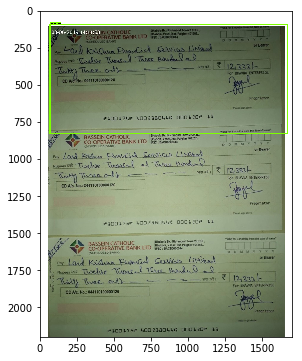

In [14]:
%matplotlib inline
for image_path in TEST_IMAGE_PATHS:
  print(image_path)
  image = Image.open(image_path)
#   plt.imshow(image)
#   plt.plot()
#   pic = cv2.imread(image_path)
#   cv2.imshow('pic',pic)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
#   print(output_dict)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.plot()

In [30]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)

# This is the way I'm getting my coordinates
boxes = output_dict['detection_boxes']
# get all boxes from an array
max_boxes_to_draw = boxes.shape[0]
# get scores to get a threshold
scores = output_dict['detection_scores']
# this is set as a default but feel free to adjust it to your needs
min_score_thresh=.5
# iterate over all objects found
coordinates = []
for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
        # boxes[i] is the box which will be drawn
        class_name = category_index[output_dict['detection_classes'][i]]['name']
        coordinates.append(boxes[i])

In [31]:
y_min = []
x_min = []
y_max = []
x_max = []

[array([0.04371905, 0.03936893, 0.37859938, 0.977966  ], dtype=float32)]

In [32]:
for i in range (len(coordinates)):
    y_min.append(image_np.shape[0] * coordinates[i][0])
    x_min.append(image_np.shape[1] * coordinates[i][1])
    y_max.append(image_np.shape[0] * coordinates[i][2])
    x_max.append(image_np.shape[1] * coordinates[i][3])

In [36]:
def crop(image_path, coords, saved_location):
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)
    cropped_image.show()
    return cropped_image

0.043719053


In [40]:
for i in range(len(coordinates):
    crop('test_image/image1.jpg', (x_min[i], y_min[i], x_max[i], y_max[i]), 'cropped' + str(i) + '.jpg')

66.92717671394348 96.18191719055176 1662.5422179698944 832.9186260700226


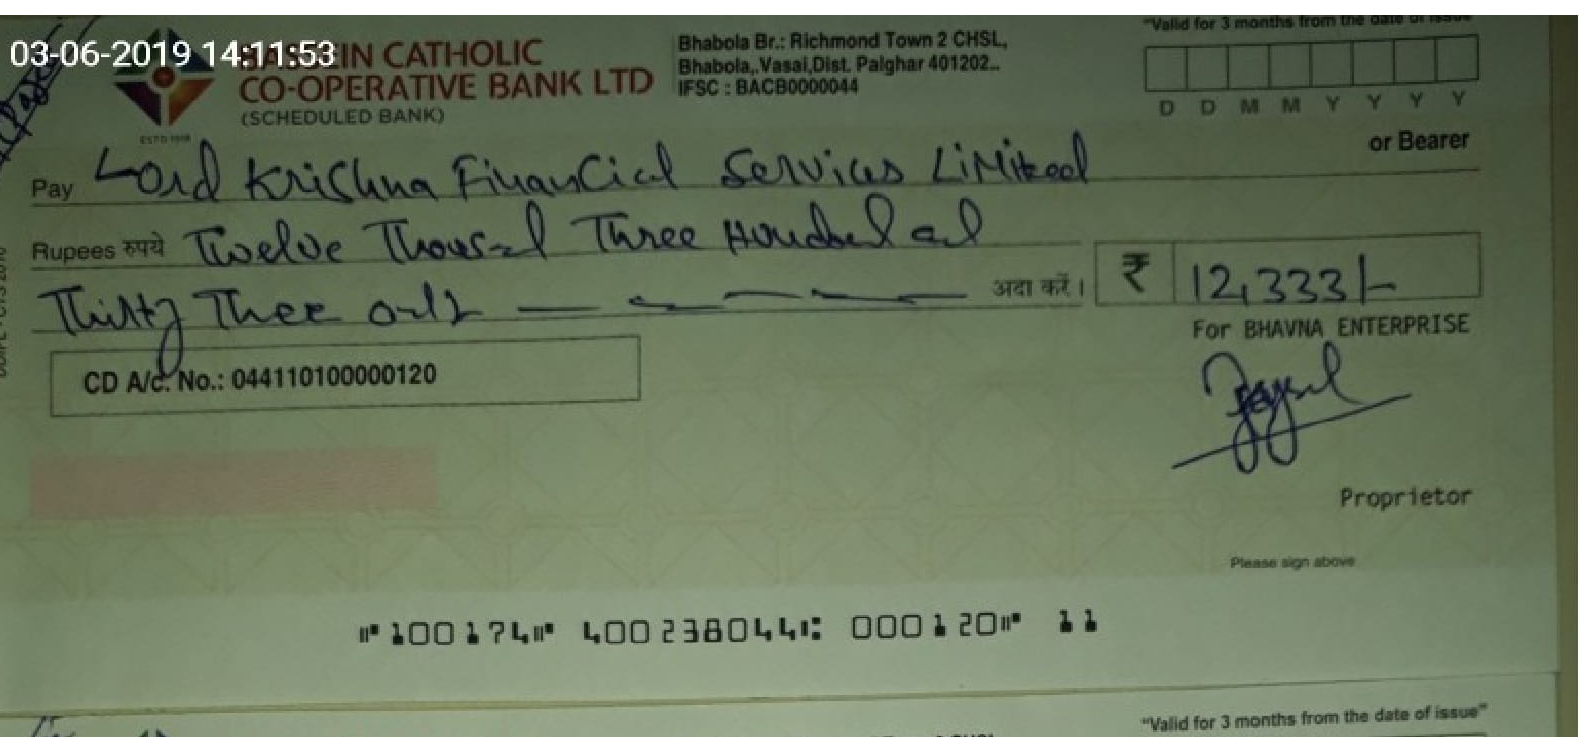

In [47]:
# crop('test_images/image3.jpg', (x_min, y_min, x_max, y_max), 'cropped.jpg')

In [3]:
def visualize_boxes_and_labels_on_image_array(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    track_ids=None,
    use_normalized_coordinates=True,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    groundtruth_box_visualization_color='black',
    skip_scores=False,
    skip_labels=False,
    skip_track_ids=False):
  """Overlay labeled boxes on an image with formatted scores and label names.
  This function groups boxes that correspond to the same location
  and creates a display string for each detection and overlays these
  on the image. Note that this function modifies the image in place, and returns
  that same image.
  Args:
    image: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    instance_masks: a numpy array of shape [N, image_height, image_width] with
      values ranging between 0 and 1, can be None.
    instance_boundaries: a numpy array of shape [N, image_height, image_width]
      with values ranging between 0 and 1, can be None.
    keypoints: a numpy array of shape [N, num_keypoints, 2], can
      be None
    track_ids: a numpy array of shape [N] with unique track ids. If provided,
      color-coding of boxes will be determined by these ids, and not the class
      indices.
    use_normalized_coordinates: whether boxes is to be interpreted as
      normalized coordinates or not.
    max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
      all boxes.
    min_score_thresh: minimum score threshold for a box to be visualized
    agnostic_mode: boolean (default: False) controlling whether to evaluate in
      class-agnostic mode or not.  This mode will display scores but ignore
      classes.
    line_thickness: integer (default: 4) controlling line width of the boxes.
    groundtruth_box_visualization_color: box color for visualizing groundtruth
      boxes
    skip_scores: whether to skip score when drawing a single detection
    skip_labels: whether to skip label when drawing a single detection
    skip_track_ids: whether to skip track id when drawing a single detection
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3) with overlaid boxes.
  """
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_instance_boundaries_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  box_to_track_ids_map = {}
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if track_ids is not None:
        box_to_track_ids_map[box] = track_ids[i]
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in six.viewkeys(category_index):
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(int(100*scores[i]))
          else:
            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
        if not skip_track_ids and track_ids is not None:
          if not display_str:
            display_str = 'ID {}'.format(track_ids[i])
          else:
            display_str = '{}: ID {}'.format(display_str, track_ids[i])
        box_to_display_str_map[box].append(display_str)
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        elif track_ids is not None:
          prime_multipler = _get_multiplier_for_color_randomness()
          box_to_color_map[box] = STANDARD_COLORS[
              (prime_multipler * track_ids[i]) % len(STANDARD_COLORS)]
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
  for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box
    if instance_masks is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_masks_map[box],
          color=color
      )
    if instance_boundaries is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_boundaries_map[box],
          color='red',
          alpha=1.0
      )
    draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)
    if keypoints is not None:
      draw_keypoints_on_image_array(
          image,
          box_to_keypoints_map[box],
          color=color,
          radius=line_thickness / 2,
          use_normalized_coordinates=use_normalized_coordinates)

  return image


In [4]:
image = cv2.imread('test_images/image3.jpg', cv2.IMREAD_UNCHANGED)
visualize_boxes_and_labels_on_image_array(image)

TypeError: visualize_boxes_and_labels_on_image_array() missing 4 required positional arguments: 'boxes', 'classes', 'scores', and 'category_index'